In [3]:
# comparisons by location and by pre and post data
import data_read
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# File paths
vivosight_folder = "data/Vivosight_data/"
scan_folder = "data/scan_information/"

# Step 1: Initialize collection
subject_ids = data_read.get_all_subject_ids(vivosight_folder)
data = {
    "Subject": [],
    "Scan ID": [],
    "Location ID": [],
    "Exposure": [],
    "Max Vessel Diameter": [],
}

# Step 2: Use process_subject_vivosight_data to get structured info
for subject_id in subject_ids:
    subject = data_read.process_subject_vivosight_data(
        subject_id, vivosight_folder, scan_folder, "bloodflow"
    )

    for visit in [subject.visit, subject.return_visit]:
        if visit and visit.blood_flow:
            # Recalculate min_location_id

            for blood_data in visit.blood_flow:
                blood_data.get_max_diameter()
                # print("check",blood_data.location)

                data["Subject"].append(subject_id)
                data["Scan ID"].append(blood_data.scan_id)
                data["Location ID"].append(blood_data.location)
                data["Exposure"].append("Post" if blood_data.exposed else "Pre")
                data["Max Vessel Diameter"].append(blood_data.max_diameter)

# Create DataFrame
df = pd.DataFrame(data)

# Remove outliers (IQR method)
Q1 = df["Max Vessel Diameter"].quantile(0.25)
Q3 = df["Max Vessel Diameter"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[
    (df["Max Vessel Diameter"] >= lower_bound) &
    (df["Max Vessel Diameter"] <= upper_bound)
]

# Step 5: Run Mann-Whitney U test for Pre vs Post per location
print("Mann-Whitney U Test: Pre vs Post by Location\n")

for loc in [1, 2, 3, 4]:
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]["Max Vessel Diameter"]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]["Max Vessel Diameter"]

    print(f" Location {loc}:")
    print(f"   Pre (n={len(pre)}), Post (n={len(post)})")

    if len(pre) >= 3 and len(post) >= 3:
        stat, p = mannwhitneyu(pre, post, alternative='two-sided')
        sig = " Significant" if p < 0.05 else "Not significant"
        print(f"   Mann-Whitney U p-value = {p:.4f} → {sig}\n")
    else:
        print("    Not enough data to compare\n")

data/Vivosight_data/A52_Results [<data_types.BloodFlow object at 0x119553650>, <data_types.BloodFlow object at 0x119a9a600>, <data_types.BloodFlow object at 0x119931340>, <data_types.BloodFlow object at 0x119553770>, <data_types.BloodFlow object at 0x119e25e80>, <data_types.BloodFlow object at 0x119e25070>, <data_types.BloodFlow object at 0x119e27aa0>, <data_types.BloodFlow object at 0x119e277d0>, <data_types.BloodFlow object at 0x119e26b10>, <data_types.BloodFlow object at 0x119e27320>, <data_types.BloodFlow object at 0x119c917f0>, <data_types.BloodFlow object at 0x119e26780>, <data_types.BloodFlow object at 0x119af6ae0>, <data_types.BloodFlow object at 0x119697c80>, <data_types.BloodFlow object at 0x119e24e30>, <data_types.BloodFlow object at 0x119e254c0>, <data_types.BloodFlow object at 0x119e24e60>, <data_types.BloodFlow object at 0x119d95910>, <data_types.BloodFlow object at 0x119d95310>, <data_types.BloodFlow object at 0x119e44800>, <data_types.BloodFlow object at 0x119e44fe0>, <

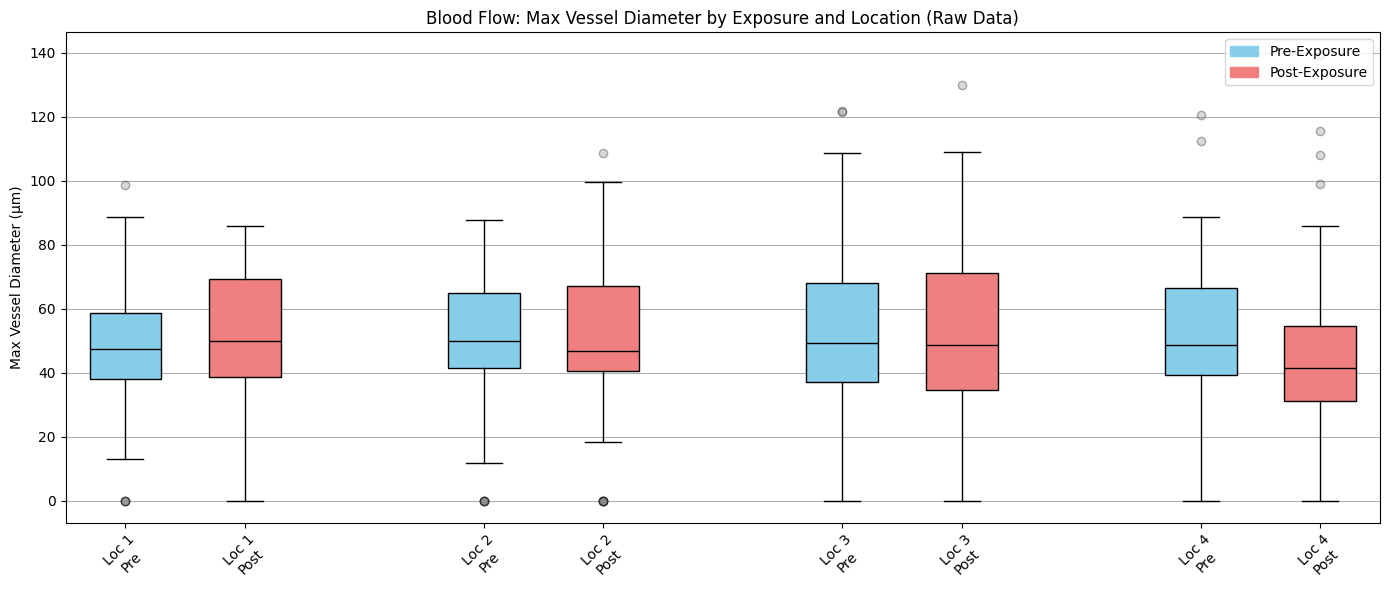

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Use the raw data without outlier removal
df_raw = df  # just for clarity; you can use df directly

# Prepare data for plotting
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []

position = 1

for loc in [1, 2, 3, 4]:
    pre = df_raw[(df_raw["Location ID"] == loc) & (df_raw["Exposure"] == "Pre")]["Max Vessel Diameter"]
    post = df_raw[(df_raw["Location ID"] == loc) & (df_raw["Exposure"] == "Post")]["Max Vessel Diameter"]

    # Pre
    plot_data.append(pre)
    plot_labels.append(f"Loc {loc}\nPre")
    plot_colors.append("skyblue")
    plot_positions.append(position)
    position += 1

    # Post
    plot_data.append(post)
    plot_labels.append(f"Loc {loc}\nPost")
    plot_colors.append("lightcoral")
    plot_positions.append(position)
    position += 2  # spacing between location groups

# Create the boxplot
plt.figure(figsize=(14, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Axis setup
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Max Vessel Diameter (µm)")
plt.title("Blood Flow: Max Vessel Diameter by Exposure and Location (Raw Data)")
plt.grid(True, axis='y')
plt.tight_layout()

# Legend
plt.legend(handles=[
    mpatches.Patch(color='skyblue', label='Pre-Exposure'),
    mpatches.Patch(color='lightcoral', label='Post-Exposure')
], loc='upper right')

plt.show()


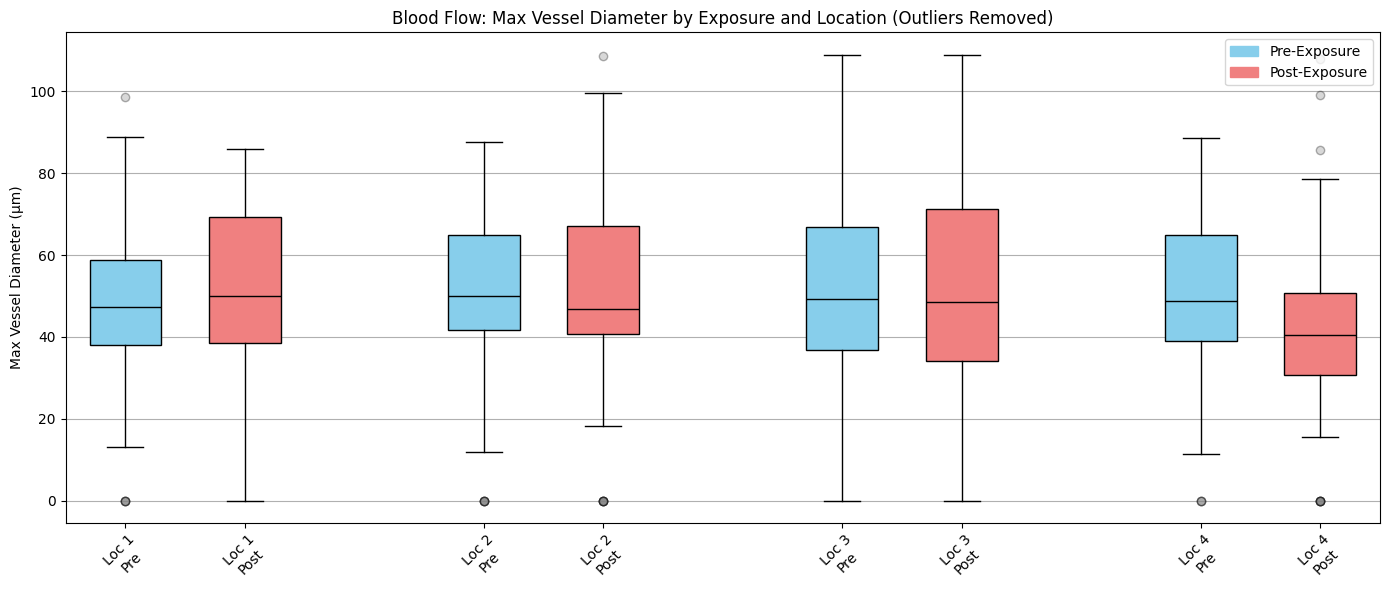

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Prepare data for plotting
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []

position = 1

for loc in [1, 2, 3, 4]:
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]["Max Vessel Diameter"]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]["Max Vessel Diameter"]

    # Pre
    plot_data.append(pre)
    plot_labels.append(f"Loc {loc}\nPre")
    plot_colors.append("skyblue")
    plot_positions.append(position)
    position += 1

    # Post
    plot_data.append(post)
    plot_labels.append(f"Loc {loc}\nPost")
    plot_colors.append("lightcoral")
    plot_positions.append(position)
    position += 2  # add spacing between location groups

# Create the boxplot
plt.figure(figsize=(14, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Axis setup
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Max Vessel Diameter (µm)")
plt.title("Blood Flow: Max Vessel Diameter by Exposure and Location (Outliers Removed)")
plt.grid(True, axis='y')
plt.tight_layout()

# Legend
plt.legend(handles=[
    mpatches.Patch(color='skyblue', label='Pre-Exposure'),
    mpatches.Patch(color='lightcoral', label='Post-Exposure')
], loc='upper right')

plt.show()

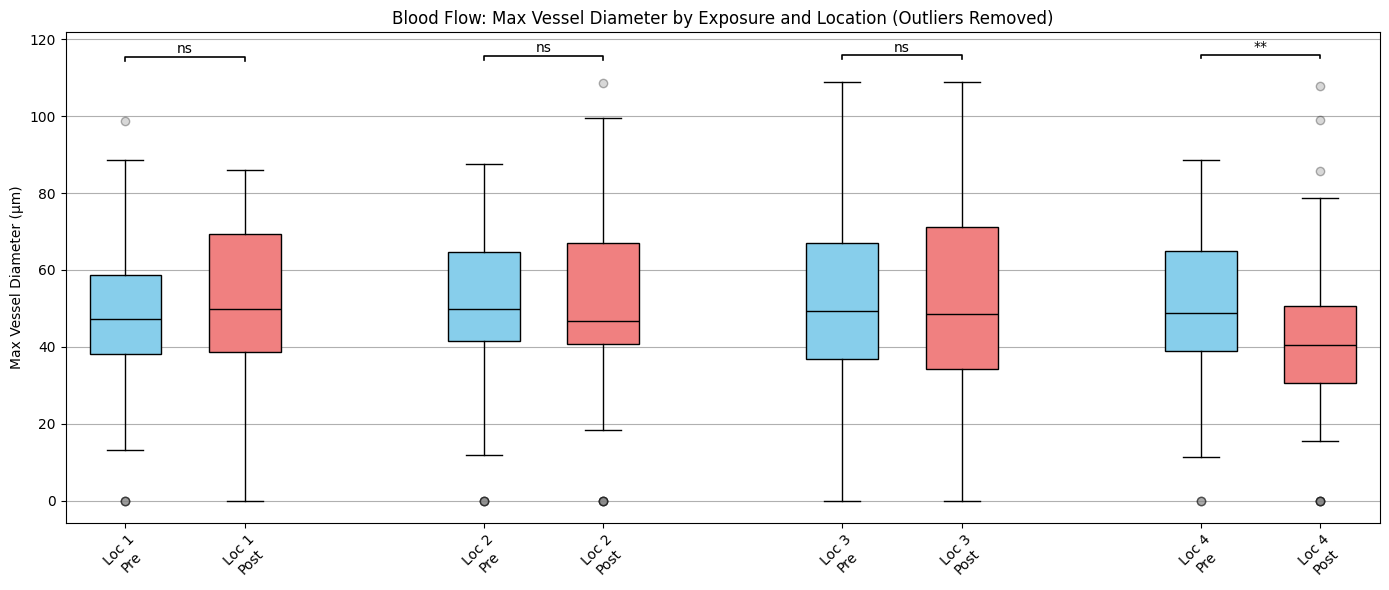

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu

# Helper function for significance annotation
def annotate_sig(ax, x1, x2, y, pval, h=1, stars=True):
    """Draws a significance bar between x1 and x2 at height y."""
    line_y = y + h
    ax.plot([x1, x1, x2, x2], [y, line_y, line_y, y], lw=1.2, c='black')
    if stars:
        if pval < 0.001:
            text = '***'
        elif pval < 0.01:
            text = '**'
        elif pval < 0.05:
            text = '*'
        else:
            text = 'ns'
    else:
        text = f"p = {pval:.3f}"
    ax.text((x1 + x2) / 2, line_y + h * 0.2, text, ha='center', va='bottom', fontsize=10)

# Prepare plot data
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []
p_values = []  # to store p-values for annotation

position = 1

for loc in [1, 2, 3, 4]:
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]["Max Vessel Diameter"]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]["Max Vessel Diameter"]

    # Pre
    plot_data.append(pre)
    plot_labels.append(f"Loc {loc}\nPre")
    plot_colors.append("skyblue")
    plot_positions.append(position)
    pre_pos = position
    position += 1

    # Post
    plot_data.append(post)
    plot_labels.append(f"Loc {loc}\nPost")
    plot_colors.append("lightcoral")
    plot_positions.append(position)
    post_pos = position
    position += 2

    # Run statistical test
    if len(pre) >= 3 and len(post) >= 3:
        stat, p = mannwhitneyu(pre, post, alternative='two-sided')
        p_values.append((pre_pos, post_pos, p))
    else:
        p_values.append((pre_pos, post_pos, None))

# Create plot
plt.figure(figsize=(14, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Format axes
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Max Vessel Diameter (µm)")
plt.title("Blood Flow: Max Vessel Diameter by Exposure and Location (Outliers Removed)")
plt.grid(True, axis='y')
plt.tight_layout()

# # Add legend
# plt.legend(handles=[
#     mpatches.Patch(color='skyblue', label='Pre-Exposure'),
#     mpatches.Patch(color='lightcoral', label='Post-Exposure')
# ], loc='upper right')

# Annotate significance
ax = plt.gca()
max_y = max([max(d) if len(d) > 0 else 0 for d in plot_data]) * 1.05

for i, (x1, x2, pval) in enumerate(p_values):
    if pval is not None:
        annotate_sig(ax, x1, x2, max_y + i * 0.2, pval)

plt.show()


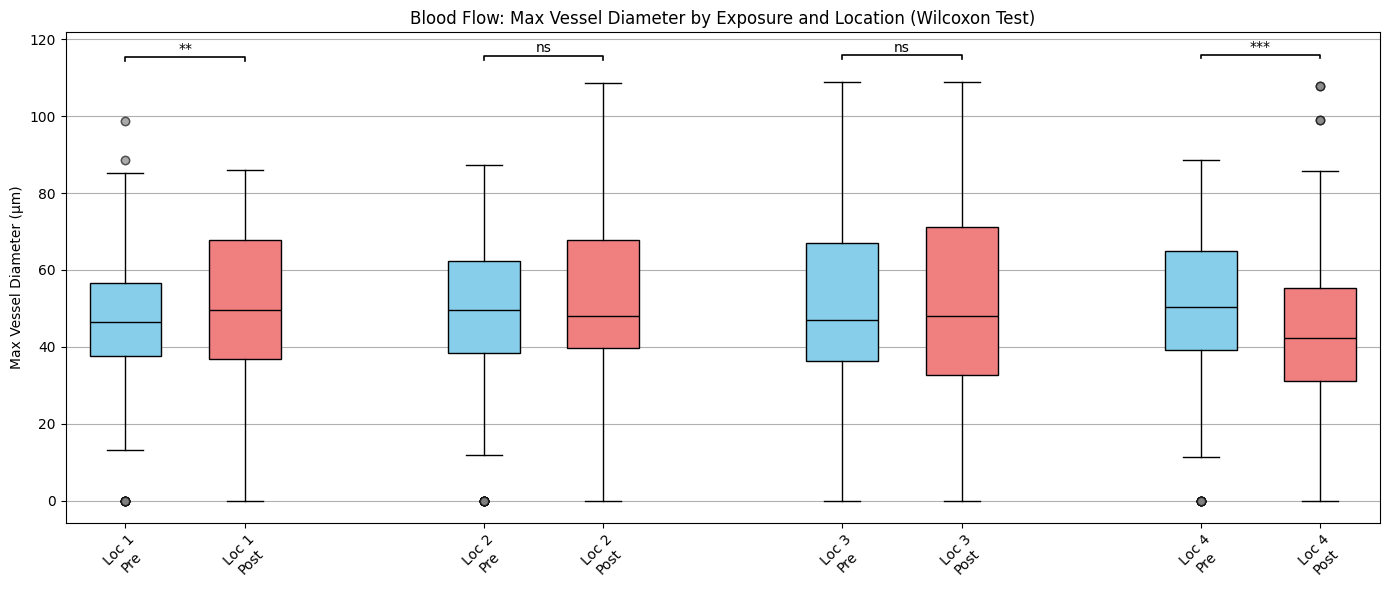

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.stats import wilcoxon

# Helper function to annotate significance
def annotate_sig(ax, x1, x2, y, pval, h=1, stars=True):
    """Draws a significance bar between x1 and x2 at height y."""
    line_y = y + h
    ax.plot([x1, x1, x2, x2], [y, line_y, line_y, y], lw=1.2, c='black')
    if stars:
        if pval < 0.001:
            text = '***'
        elif pval < 0.01:
            text = '**'
        elif pval < 0.05:
            text = '*'
        else:
            text = 'ns'
    else:
        text = f"p = {pval:.3f}"
    ax.text((x1 + x2) / 2, line_y + h * 0.2, text, ha='center', va='bottom', fontsize=10)

# Initialize containers
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []
p_values = []  # for annotations

position = 1

# Loop through locations
for loc in [1, 2, 3, 4]:
    # Subset data
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]

    # Merge by Subject to get paired data
    merged = pd.merge(pre, post, on="Subject", suffixes=("_pre", "_post"))
    pre_vals = merged["Max Vessel Diameter_pre"]
    post_vals = merged["Max Vessel Diameter_post"]

    # Store data for plotting
    plot_data.append(pre_vals)
    plot_labels.append(f"Loc {loc}\nPre")
    plot_colors.append("skyblue")
    plot_positions.append(position)
    pre_pos = position
    position += 1

    plot_data.append(post_vals)
    plot_labels.append(f"Loc {loc}\nPost")
    plot_colors.append("lightcoral")
    plot_positions.append(position)
    post_pos = position
    position += 2

    # Wilcoxon test (requires at least 3 pairs)
    if len(pre_vals) >= 3:
        stat, p = wilcoxon(pre_vals, post_vals)
        p_values.append((pre_pos, post_pos, p))
    else:
        p_values.append((pre_pos, post_pos, None))

# Create boxplot
plt.figure(figsize=(14, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Format axes
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Max Vessel Diameter (μm)")
plt.title("Blood Flow: Max Vessel Diameter by Exposure and Location (Wilcoxon Test)")
plt.grid(True, axis='y')
plt.tight_layout()

# Add significance annotations
ax = plt.gca()
max_y = max([max(d) if len(d) > 0 else 0 for d in plot_data]) * 1.05

for i, (x1, x2, pval) in enumerate(p_values):
    if pval is not None:
        annotate_sig(ax, x1, x2, max_y + i * 0.2, pval)

plt.show()

Wilcoxon Signed-Rank Test Results (Pre vs Post for Max Vessel Diameter):
Location 1: p = 0.0053
Location 2: p = 0.0686
Location 3: p = 0.7455
Location 4: p = 0.0000


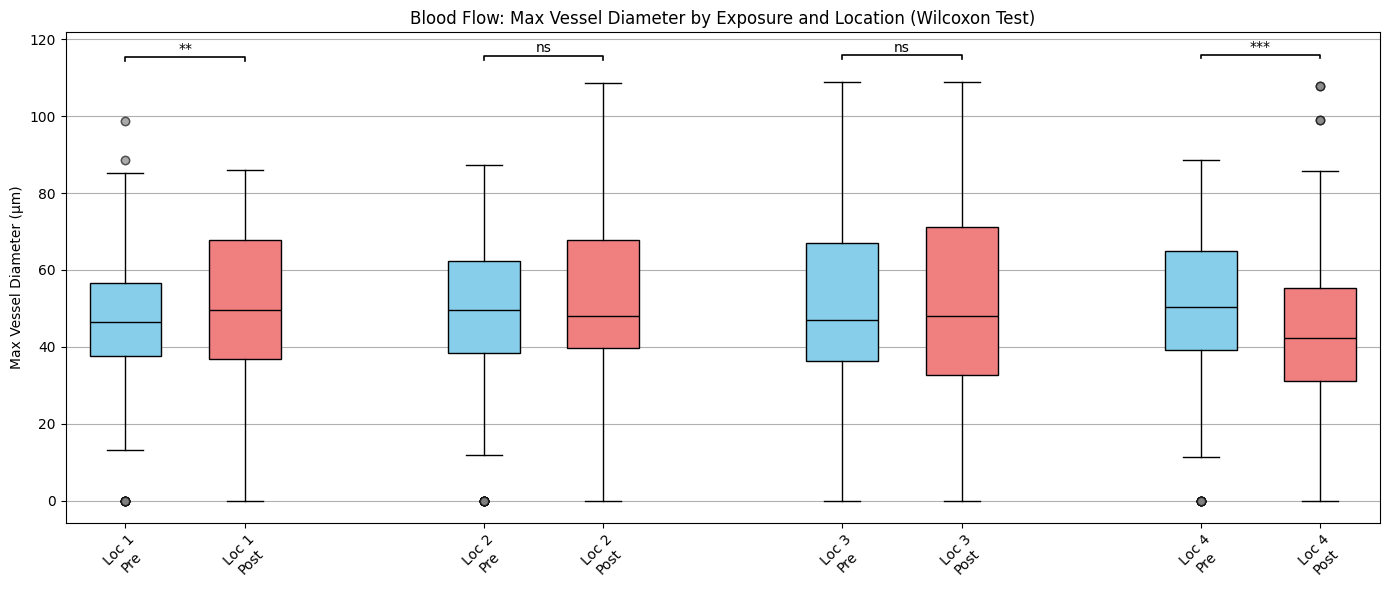

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.stats import wilcoxon

# Helper function for significance annotation
def annotate_sig(ax, x1, x2, y, pval, h=1, stars=True):
    """Draws a significance bar between x1 and x2 at height y."""
    line_y = y + h
    ax.plot([x1, x1, x2, x2], [y, line_y, line_y, y], lw=1.2, c='black')
    if stars:
        if pval < 0.001:
            text = '***'
        elif pval < 0.01:
            text = '**'
        elif pval < 0.05:
            text = '*'
        else:
            text = 'ns'
    else:
        text = f"p = {pval:.3f}"
    ax.text((x1 + x2) / 2, line_y + h * 0.2, text, ha='center', va='bottom', fontsize=10)

# Initialize containers
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []
p_values = []

position = 1

print("Wilcoxon Signed-Rank Test Results (Pre vs Post for Max Vessel Diameter):")
print("=======================================================================")

for loc in [1, 2, 3, 4]:
    # Subset pre and post
    pre = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Pre")]
    post = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == "Post")]

    # Merge by Subject to get paired measurements
    merged = pd.merge(pre, post, on="Subject", suffixes=("_pre", "_post"))
    pre_vals = merged["Max Vessel Diameter_pre"]
    post_vals = merged["Max Vessel Diameter_post"]

    # Store for boxplot
    plot_data.append(pre_vals)
    plot_labels.append(f"Loc {loc}\nPre")
    plot_colors.append("skyblue")
    plot_positions.append(position)
    pre_pos = position
    position += 1

    plot_data.append(post_vals)
    plot_labels.append(f"Loc {loc}\nPost")
    plot_colors.append("lightcoral")
    plot_positions.append(position)
    post_pos = position
    position += 2

    # Run Wilcoxon signed-rank test
    if len(pre_vals) >= 3:
        stat, p = wilcoxon(pre_vals, post_vals)
        print(f"Location {loc}: p = {p:.4f}")
        p_values.append((pre_pos, post_pos, p))
    else:
        print(f"Location {loc}: Not enough paired data for Wilcoxon test (n={len(pre_vals)})")
        p_values.append((pre_pos, post_pos, None))

# Create boxplot
plt.figure(figsize=(14, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Format axes
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Max Vessel Diameter (μm)")
plt.title("Blood Flow: Max Vessel Diameter by Exposure and Location (Wilcoxon Test)")
plt.grid(True, axis='y')
plt.tight_layout()

# Annotate significance
ax = plt.gca()
max_y = max([max(d) if len(d) > 0 else 0 for d in plot_data]) * 1.05

for i, (x1, x2, pval) in enumerate(p_values):
    if pval is not None:
        annotate_sig(ax, x1, x2, max_y + i * 0.2, pval)

plt.show()


data/Vivosight_data/A52_Results [<data_types.BloodFlow object at 0x11c5c01d0>, <data_types.BloodFlow object at 0x11c775df0>, <data_types.BloodFlow object at 0x11c776f60>, <data_types.BloodFlow object at 0x11c568e90>, <data_types.BloodFlow object at 0x119ee7440>, <data_types.BloodFlow object at 0x11c892c60>, <data_types.BloodFlow object at 0x11c58bd70>, <data_types.BloodFlow object at 0x119de0440>, <data_types.BloodFlow object at 0x11c49b8f0>, <data_types.BloodFlow object at 0x11c499a30>, <data_types.BloodFlow object at 0x11a2c0bc0>, <data_types.BloodFlow object at 0x11c499d90>, <data_types.BloodFlow object at 0x11c499790>, <data_types.BloodFlow object at 0x11c498770>, <data_types.BloodFlow object at 0x11c49ae70>, <data_types.BloodFlow object at 0x11c8e3320>, <data_types.BloodFlow object at 0x11c8e1460>, <data_types.BloodFlow object at 0x11c8e09e0>, <data_types.BloodFlow object at 0x11c5c21e0>, <data_types.BloodFlow object at 0x11c618140>, <data_types.BloodFlow object at 0x11c61a690>, <

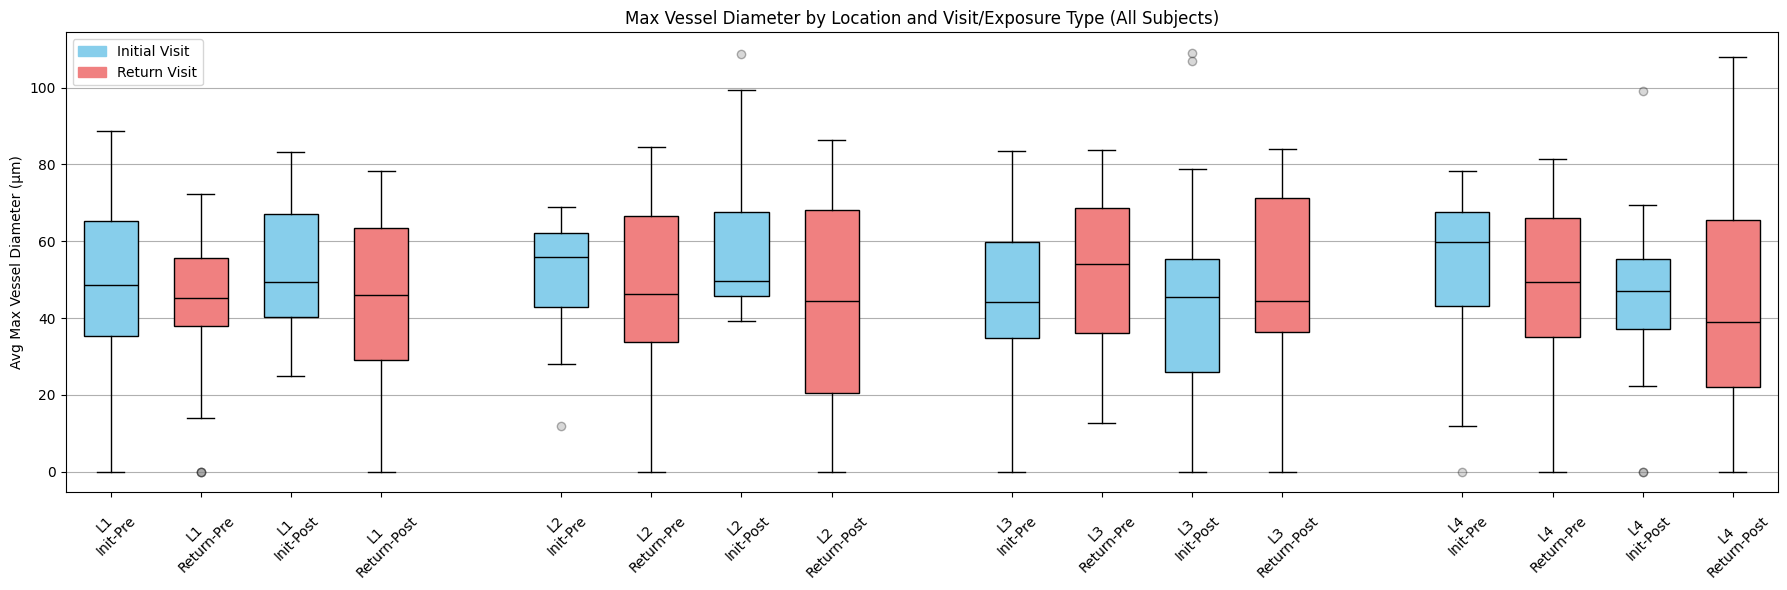

In [33]:
import data_read
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# def compute_avg_by_location(scan_list):
#     pre = {1: [], 2: [], 3: [], 4: []}
#     post = {1: [], 2: [], 3: [], 4: []}

#     for scan in scan_list:
#         if scan.location not in [1, 2, 3, 4]:
#             continue
#         try:
#             max_diameter = max(scan.blood_data["Vessel Diameter"])
#         except:
#             continue
#         if scan.exposed:
#             post[scan.location].append(max_diameter)
#         else:
#             pre[scan.location].append(max_diameter)

#     pre_avg = {loc: np.mean(vals) for loc, vals in pre.items() if vals}
#     post_avg = {loc: np.mean(vals) for loc, vals in post.items() if vals}
#     return pre_avg, post_avg


# Setup paths
vivosight_folder = "data/Vivosight_data/"
scan_folder = "data/scan_information/"
subject_ids = data_read.get_all_subject_ids(vivosight_folder)

# Initialize containers
initial_pre_vessel = {1: [], 2: [], 3: [], 4: []}
initial_post_vessel = {1: [], 2: [], 3: [], 4: []}
return_pre_vessel = {1: [], 2: [], 3: [], 4: []}
return_post_vessel = {1: [], 2: [], 3: [], 4: []}

# Loop through each subject
for subject_id in subject_ids:
    subject = data_read.process_subject_vivosight_data(subject_id, vivosight_folder, scan_folder, "bloodflow")

    if subject.visit is None or subject.return_visit is None:
        continue

    # Compute averages for initial and return visits
    for blood_flow in subject.visit.blood_flow:
        blood_flow.get_max_diameter()
        if blood_flow.location not in [1, 2, 3, 4]:
            continue
        if blood_flow.exposed:
            initial_post_vessel[blood_flow.location].append(blood_flow.max_diameter)
        else:
            initial_pre_vessel[blood_flow.location].append(blood_flow.max_diameter)

    for blood_flow in subject.return_visit.blood_flow:
        blood_flow.get_max_diameter()
        if blood_flow.location not in [1, 2, 3, 4]:
            continue
        if blood_flow.exposed:
            return_post_vessel[blood_flow.location].append(blood_flow.max_diameter)
        else:
            return_pre_vessel[blood_flow.location].append(blood_flow.max_diameter)



# === Plotting ===
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []

position = 1

for loc in [1, 2, 3, 4]:
    # Initial Pre
    plot_data.append(initial_pre_vessel[loc])
    plot_labels.append(f"L{loc}\nInit-Pre")
    plot_colors.append('skyblue')
    plot_positions.append(position)
    position += 1

    # Return Pre
    plot_data.append(return_pre_vessel[loc])
    plot_labels.append(f"L{loc}\nReturn-Pre")
    plot_colors.append('lightcoral')
    plot_positions.append(position)
    position += 1

    # Initial Post
    plot_data.append(initial_post_vessel[loc])
    plot_labels.append(f"L{loc}\nInit-Post")
    plot_colors.append('skyblue')
    plot_positions.append(position)
    position += 1

    # Return Post
    plot_data.append(return_post_vessel[loc])
    plot_labels.append(f"L{loc}\nReturn-Post")
    plot_colors.append('lightcoral')
    plot_positions.append(position)
    position += 2  # spacing between locations

# Create boxplot
plt.figure(figsize=(18, 6))

for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

# Format axes
plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Avg Max Vessel Diameter (μm)")
plt.title("Max Vessel Diameter by Location and Visit/Exposure Type (All Subjects)")
plt.grid(True, axis='y')
plt.tight_layout()

# Add legend
plt.legend(handles=[
    mpatches.Patch(color='skyblue', label='Initial Visit'),
    mpatches.Patch(color='lightcoral', label='Return Visit')
], loc='upper left')

plt.show()

data/Vivosight_data/A52_Results [<data_types.BloodFlow object at 0x11c8c82c0>, <data_types.BloodFlow object at 0x11c5c3f50>, <data_types.BloodFlow object at 0x11c4acce0>, <data_types.BloodFlow object at 0x11c93aed0>, <data_types.BloodFlow object at 0x11c498680>, <data_types.BloodFlow object at 0x119e46c30>, <data_types.BloodFlow object at 0x11c8e4a70>, <data_types.BloodFlow object at 0x11cb1f920>, <data_types.BloodFlow object at 0x11c936f90>, <data_types.BloodFlow object at 0x11cb1ef00>, <data_types.BloodFlow object at 0x11cb1e840>, <data_types.BloodFlow object at 0x11c8b6d20>, <data_types.BloodFlow object at 0x11c9062a0>, <data_types.BloodFlow object at 0x11c50c620>, <data_types.BloodFlow object at 0x11cb1e1e0>, <data_types.BloodFlow object at 0x11cb1d910>, <data_types.BloodFlow object at 0x11c974e90>, <data_types.BloodFlow object at 0x11c905070>, <data_types.BloodFlow object at 0x11c52d490>, <data_types.BloodFlow object at 0x11c52f4d0>, <data_types.BloodFlow object at 0x11c8b4380>, <

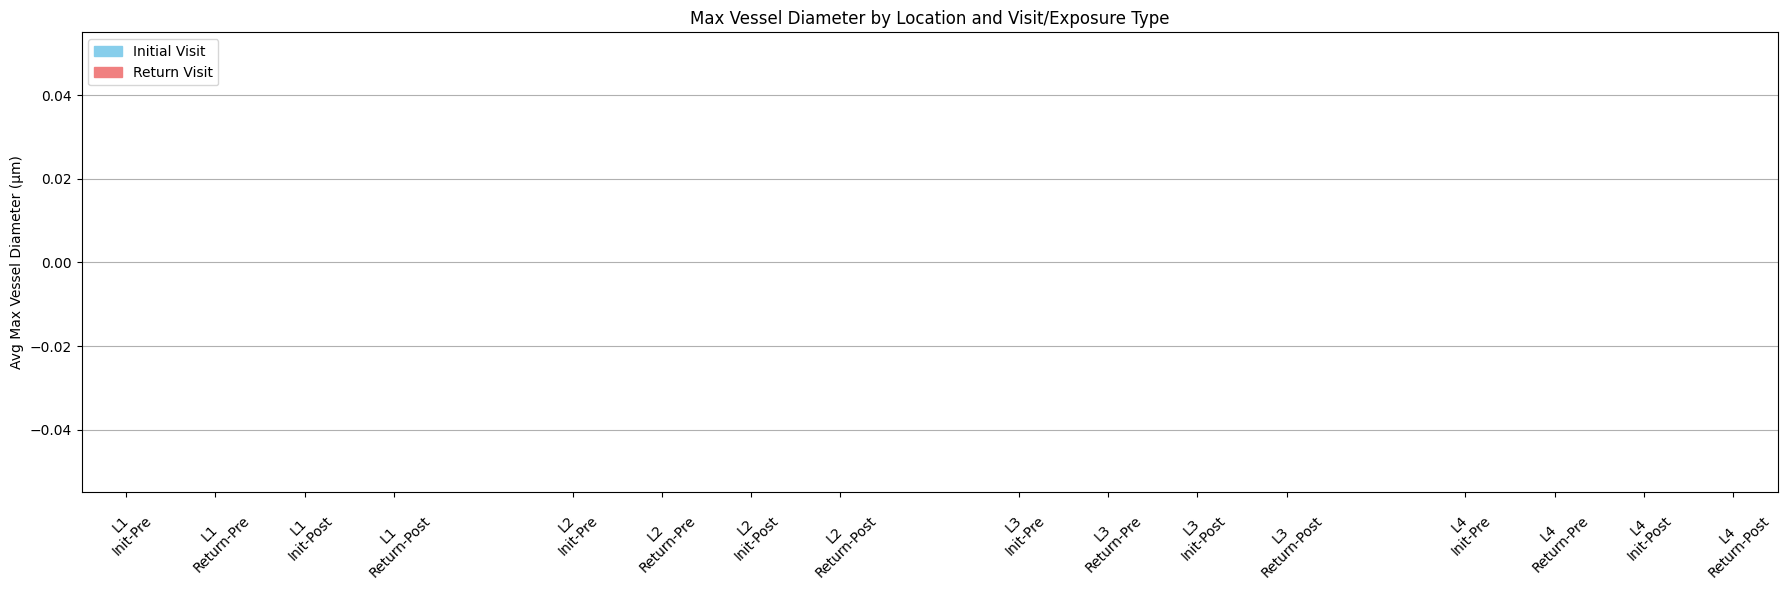

In [27]:
import data_read
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Setup paths
vivosight_folder = "data/Vivosight_data/"
scan_folder = "data/scan_information/"
subject_ids = data_read.get_all_subject_ids(vivosight_folder)

# Initialize containers for each visit/exposure category
initial_pre_avg_vessel = {1: [], 2: [], 3: [], 4: []}
initial_post_avg_vessel = {1: [], 2: [], 3: [], 4: []}
return_pre_avg_vessel = {1: [], 2: [], 3: [], 4: []}
return_post_avg_vessel = {1: [], 2: [], 3: [], 4: []}

# Loop through each subject
for subject_id in subject_ids:
    subject = data_read.process_subject_vivosight_data(subject_id, vivosight_folder, scan_folder, "bloodflow")

    if subject.visit is None or subject.return_visit is None:
        continue

    def compute_avg_by_location(scan_list):
        pre = {1: [], 2: [], 3: [], 4: []}
        post = {1: [], 2: [], 3: [], 4: []}
        for scan in scan_list:
            if scan.location not in [1, 2, 3, 4]:
                continue
            try:
                max_diameter = max(scan.blood_data["Vessel Diameter"])
            except Exception:
                continue
            if scan.exposed:
                post[scan.location].append(max_diameter)
            else:
                pre[scan.location].append(max_diameter)
        pre_avg = {loc: np.mean(vals) for loc, vals in pre.items() if vals}
        post_avg = {loc: np.mean(vals) for loc, vals in post.items() if vals}
        return pre_avg, post_avg

    init_pre, init_post = compute_avg_by_location(subject.visit.blood_flow)
    ret_pre, ret_post = compute_avg_by_location(subject.return_visit.blood_flow)

    for loc in [1, 2, 3, 4]:
        if loc in init_pre:
            initial_pre_avg_vessel[loc].append(init_pre[loc])
        if loc in init_post:
            initial_post_avg_vessel[loc].append(init_post[loc])
        if loc in ret_pre:
            return_pre_avg_vessel[loc].append(ret_pre[loc])
        if loc in ret_post:
            return_post_avg_vessel[loc].append(ret_post[loc])

# === Plotting ===
plot_data = []
plot_labels = []
plot_colors = []
plot_positions = []

position = 1

for loc in [1, 2, 3, 4]:
    plot_data.append(initial_pre_avg_vessel[loc])
    plot_labels.append(f"L{loc}\nInit-Pre")
    plot_colors.append('skyblue')
    plot_positions.append(position)
    position += 1

    plot_data.append(return_pre_avg_vessel[loc])
    plot_labels.append(f"L{loc}\nReturn-Pre")
    plot_colors.append('lightcoral')
    plot_positions.append(position)
    position += 1

    plot_data.append(initial_post_avg_vessel[loc])
    plot_labels.append(f"L{loc}\nInit-Post")
    plot_colors.append('skyblue')
    plot_positions.append(position)
    position += 1

    plot_data.append(return_post_avg_vessel[loc])
    plot_labels.append(f"L{loc}\nReturn-Post")
    plot_colors.append('lightcoral')
    plot_positions.append(position)
    position += 2

# Create the plot
plt.figure(figsize=(18, 6))
for i in range(len(plot_data)):
    plt.boxplot(
        plot_data[i],
        positions=[plot_positions[i]],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=plot_colors[i], color='black'),
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markerfacecolor='gray', marker='o', alpha=0.3)
    )

plt.xticks(plot_positions, plot_labels, rotation=45)
plt.ylabel("Avg Max Vessel Diameter (μm)")
plt.title("Max Vessel Diameter by Location and Visit/Exposure Type")
plt.grid(True, axis='y')
plt.tight_layout()

plt.legend(handles=[
    mpatches.Patch(color='skyblue', label='Initial Visit'),
    mpatches.Patch(color='lightcoral', label='Return Visit')
], loc='upper left')

plt.show()


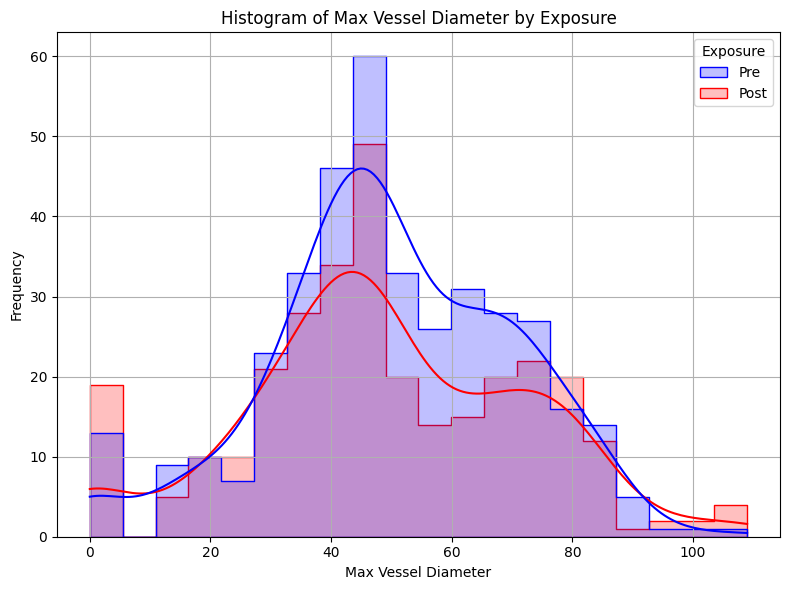

In [5]:
import data_read
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

# Separated histograms by Exposure
plt.figure(figsize=(8, 6))
sns.histplot(data=df_clean, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Histogram of Max Vessel Diameter by Exposure")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

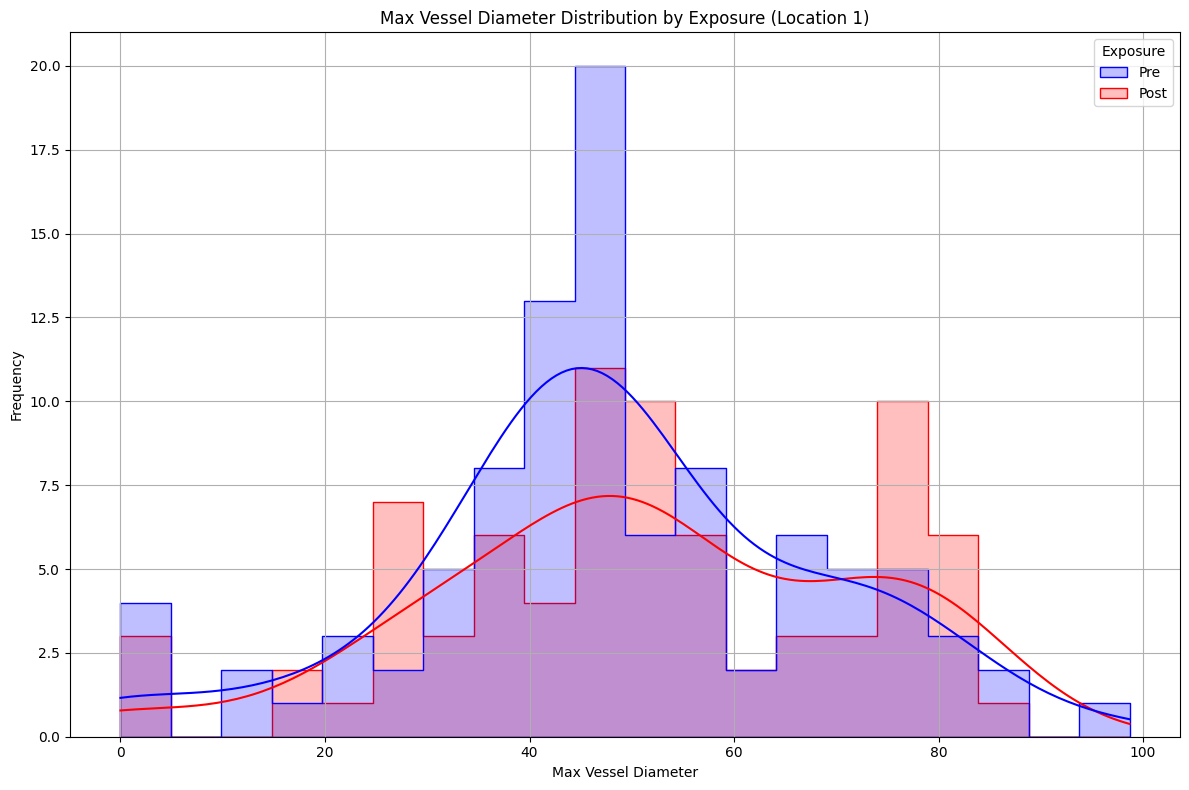

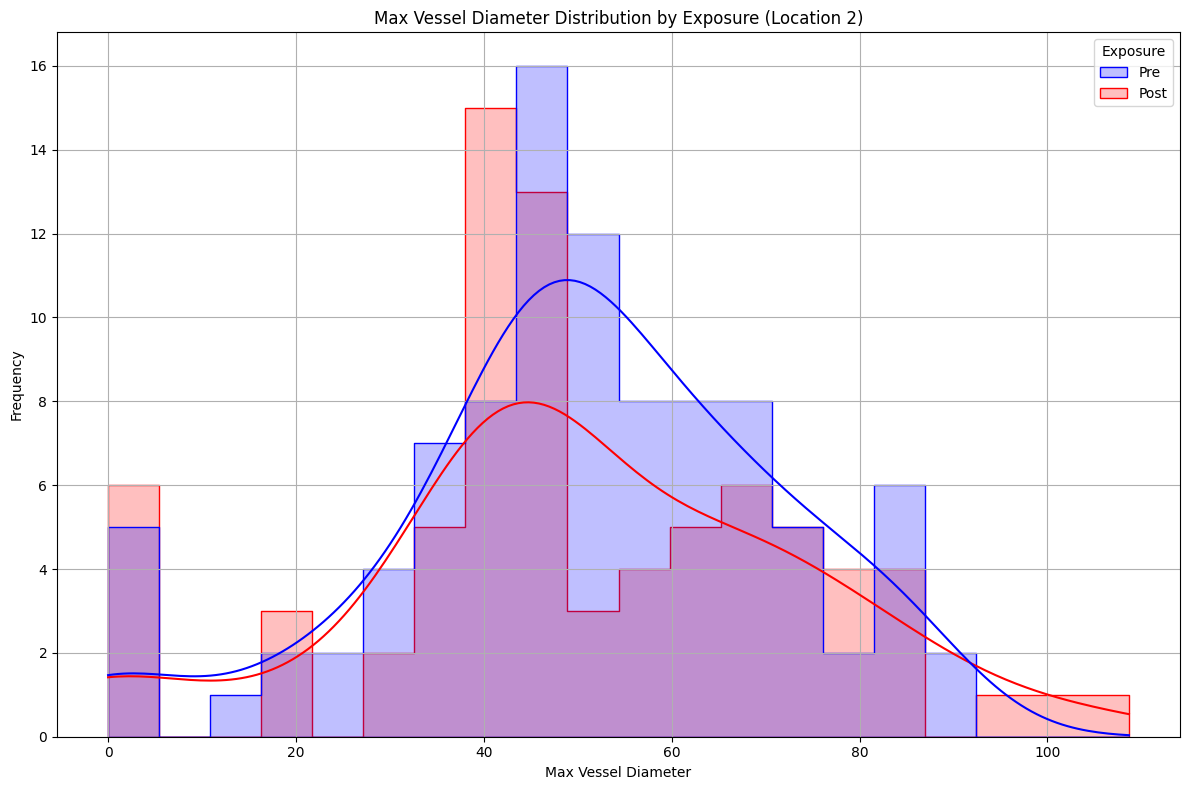

In [6]:
import data_read
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter the data for Locations 1 and 2
df_location_1 = df_clean[df_clean["Location ID"] == 1]
df_location_2 = df_clean[df_clean["Location ID"] == 2]

# Create histogram for Location 1 (Pre and Post exposure)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_location_1, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Max Vessel Diameter Distribution by Exposure (Location 1)")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Create histogram for Location 2 (Pre and Post exposure)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_location_2, x="Max Vessel Diameter", hue="Exposure", bins=20, kde=True,
             palette={"Pre": "blue", "Post": "red"}, element="step", stat="count", common_norm=False)
plt.title("Max Vessel Diameter Distribution by Exposure (Location 2)")
plt.xlabel("Max Vessel Diameter")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Calculate mean, median, and standard deviation for Location 1
location_1_stats = df_clean[df_clean["Location ID"] == 1]["Max Vessel Diameter"].agg(['mean', 'median', 'std'])

# Calculate mean, median, and standard deviation for Location 2
location_2_stats = df_clean[df_clean["Location ID"] == 2]["Max Vessel Diameter"].agg(['mean', 'median', 'std'])

# Print the results
print("Location 1 Stats:")
print(location_1_stats)
print("\nLocation 2 Stats:")
print(location_2_stats)

Location 1 Stats:
mean      49.564397
median    48.179754
std       20.264797
Name: Max Vessel Diameter, dtype: float64

Location 2 Stats:
mean      50.550279
median    48.379006
std       21.906616
Name: Max Vessel Diameter, dtype: float64


In [24]:
# Define function to calculate and format quartiles
def get_quartiles(series):
    return {
        "Q1 (25th percentile)": series.quantile(0.25),
        "Median (50th percentile)": series.median(),
        "Q3 (75th percentile)": series.quantile(0.75)
    }

# Iterate through locations and exposure types
for loc in [1, 2, 3, 4]:
    for exposure in ["Pre", "Post"]:
        subset = df_clean[(df_clean["Location ID"] == loc) & (df_clean["Exposure"] == exposure)]["Max Vessel Diameter"].dropna()
        
        if len(subset) < 1:
            print(f"\n📌 Location {loc} - {exposure} Exposure: No data available")
            continue
        
        quartiles = get_quartiles(subset)
        
        print(f"\n📌 Location {loc} - {exposure} Exposure")
        print("=" * 40)
        for stat, value in quartiles.items():
            print(f"{stat}: {value:.4f}")


📌 Location 1 - Pre Exposure
Q1 (25th percentile): 38.0080
Median (50th percentile): 47.3095
Q3 (75th percentile): 58.7879

📌 Location 1 - Post Exposure
Q1 (25th percentile): 38.5410
Median (50th percentile): 49.8830
Q3 (75th percentile): 69.2663

📌 Location 2 - Pre Exposure
Q1 (25th percentile): 41.5749
Median (50th percentile): 49.9574
Q3 (75th percentile): 64.7969

📌 Location 2 - Post Exposure
Q1 (25th percentile): 40.6451
Median (50th percentile): 46.7875
Q3 (75th percentile): 66.9824

📌 Location 3 - Pre Exposure
Q1 (25th percentile): 36.8174
Median (50th percentile): 49.2013
Q3 (75th percentile): 66.9360

📌 Location 3 - Post Exposure
Q1 (25th percentile): 34.1542
Median (50th percentile): 48.4599
Q3 (75th percentile): 71.2594

📌 Location 4 - Pre Exposure
Q1 (25th percentile): 39.0431
Median (50th percentile): 48.7399
Q3 (75th percentile): 64.9751

📌 Location 4 - Post Exposure
Q1 (25th percentile): 30.6146
Median (50th percentile): 40.5471
Q3 (75th percentile): 50.7131


In [25]:
from scipy.stats import wilcoxon
import pandas as pd

print("📊 Wilcoxon Signed-Rank Test: Pre vs Post Exposure")
print("==================================================")

# Loop through each location
for loc in [1, 2, 3, 4]:
    # Filter for current location
    df_loc = df_clean[df_clean["Location ID"] == loc]

    # Group by Subject and Exposure and compute mean if multiple scans exist
    grouped = df_loc.groupby(["Subject", "Exposure"])["Max Vessel Diameter"].mean().reset_index()

    # Pivot so each subject has one row with Pre and Post values
    pivoted = grouped.pivot(index="Subject", columns="Exposure", values="Max Vessel Diameter")

    # Drop subjects missing either pre or post
    pivoted = pivoted.dropna(subset=["Pre", "Post"])

    pre_vals = pivoted["Pre"]
    post_vals = pivoted["Post"]

    if len(pre_vals) >= 3:
        stat, p = wilcoxon(pre_vals, post_vals)
        print(f"Location {loc}: n = {len(pre_vals)} → p-value = {p:.4f}")
    else:
        print(f"Location {loc}: Not enough paired data for Wilcoxon test (n = {len(pre_vals)})")


📊 Wilcoxon Signed-Rank Test: Pre vs Post Exposure
Location 1: n = 19 → p-value = 0.5153
Location 2: n = 19 → p-value = 0.7983
Location 3: n = 19 → p-value = 0.6226
Location 4: n = 19 → p-value = 0.0108


In [8]:
from scipy.stats import mannwhitneyu

# Get data for Location 1 and Location 2
location_1_data = df_clean[df_clean["Location ID"] == 1]["Max Vessel Diameter"]
location_2_data = df_clean[df_clean["Location ID"] == 2]["Max Vessel Diameter"]

# Perform Mann-Whitney U test (non-parametric test)
stat, p_value = mannwhitneyu(location_1_data, location_2_data, alternative='two-sided')

# Print result
print(f"Mann-Whitney U test p-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between the two locations.")
else:
    print("There is no significant difference between the two locations.")

Mann-Whitney U test p-value: 0.5722
There is no significant difference between the two locations.


In [17]:
from scipy.stats import wilcoxon

# Pivot the data: rows = Subject, columns = Location, values = Max Vessel Diameter
paired_data = df_clean.pivot(index="Subject", columns="Location ID", values="Max Vessel Diameter")

# Drop subjects missing either location
paired_data = paired_data.dropna(subset=[1, 2])

# Extract paired data
location_1 = paired_data[1]
location_2 = paired_data[2]

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(location_1, location_2)

# Output results
print(f"Wilcoxon signed-rank test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("✅ There is a significant difference in Max Vessel Diameter between Location 1 and Location 2 (paired).")
else:
    print("❌ There is no significant difference in Max Vessel Diameter between Location 1 and Location 2 (paired).")

ValueError: Index contains duplicate entries, cannot reshape

In [16]:
print(df_clean.columns)


Index(['Subject', 'Scan ID', 'Location ID', 'Exposure', 'Max Vessel Diameter'], dtype='object')


In [9]:
from scipy.stats import mannwhitneyu

# Get data for Location 3 and Location 4
location_3_data = df_clean[df_clean["Location ID"] == 3]["Max Vessel Diameter"]
location_4_data = df_clean[df_clean["Location ID"] == 4]["Max Vessel Diameter"]

# Perform Mann-Whitney U test (non-parametric test)
stat, p_value = mannwhitneyu(location_3_data, location_4_data, alternative='two-sided')

# Print result
print(f"Mann-Whitney U test p-value for Locations 3 vs 4: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between Locations 3 and 4.")
else:
    print("There is no significant difference between Locations 3 and 4.")


Mann-Whitney U test p-value for Locations 3 vs 4: 0.0657
There is no significant difference between Locations 3 and 4.
